In [2]:
'''
Trains a simple deep RNN on the MNIST dataset.
'''
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import itertools


batch_size = 32
num_classes = 10
epochs = 2

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 1, 784)
x_test = x_test.reshape(10000, 1, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train = y_train.reshape(60000,10)
y_test = y_test.reshape(10000,10)

model = Sequential()
model.add(keras.layers.recurrent.SimpleRNN(100, input_dim=784, input_length=1, return_sequences=True))
# model.add(keras.layers.recurrent.SimpleRNN(32, return_sequences=True))
# model.add(keras.layers.recurrent.SimpleRNN(16, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform',
#                                  recurrent_initializer='orthogonal', bias_initializer='zeros',
#                                  kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
#                                  activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None,
#                                  bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
model.add(keras.layers.recurrent.SimpleRNN(10))

model.summary()

Using TensorFlow backend.


60000 train samples
10000 test samples


/home/asagodi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/asagodi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(100, return_sequences=True, input_shape=(1, 784))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1, 100)            88500     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                1110      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 10s - loss: 9.0730 - acc: 0.1857 - val_loss: 8.7882 - val_acc: 0.1403
Epoch 2/2
60000/60000 [==============================] - 9s - loss: 9.2809 - acc: 0.1604 - val_loss: 8.9952 - val_acc: 0.1944
Test loss: 8.99519557343
Test accuracy: 0.1944


In [3]:
#getting the recurrent weights like this is BS
import tensorflow as tf
x = model.weights[4]

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
weight_mat = sess.run(x)    
# print(v) # will show you your variable.

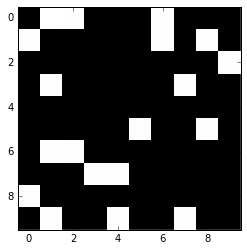

In [4]:
plt.imshow(weight_mat>0.2, interpolation='none', cmap=plt.cm.gray) 
plt.show()

In [5]:
def find_pattern_by_weight(neuron, weight_matrix, min_weight):
    current_neuron = neuron
    list_of_paths = [[neuron]] #paths are lists
    while True:
        for path in list_of_paths:
            current_neuron = path[-1]
            next_neurons = close_neighbours(current_neuron, weight_matrix, min_weight) #select close neighbours
            #add next neuron in path
            extended_paths = []
            for nn in next_neurons:
                if nn not in path:
                    extended_paths.append(path + [nn])
        print(extended_paths)
        if extended_paths == []:
            break
        for ep in extended_paths:
            if ep not in list_of_paths:
                extended_paths.append(ep)
        
    return list_of_paths

In [6]:
def close_neighbours(neuron, weight_matrix, min_weight):
    """
    Returns a list of neighbours that have a connection strength above min_weight.
    """
    neighs = weight_matrix[neuron] #select connections to neighbours
    cn = [abs(neighs) > min_weight] #select close neighbours
    close_neuron_numbers = np.squeeze(np.arange(0, weight_matrix.shape[1]))[cn]
    return close_neuron_numbers

In [7]:
def find_pattern_by_weight(neuron, weight_matrix, min_weight, max_length):
    """
    Returns a list of all patterns that have a connection neurons with connection 
    strength above min_weight and are of maximal size max_length.
    """
    current_neuron = neuron
    list_of_paths = [[neuron]] #paths are lists
    dict_of_paths = {}
    i = 1
    while i < max_length:
        eep = []
        for path in list_of_paths:
#             print("Path", path)
            current_neuron = path[-1]
#             print("Current", current_neuron)
            next_neurons = close_neighbours(current_neuron, weight_matrix, min_weight) #select close neighbours
#             print("Next", next_neurons)
            #add next neuron in path
            extended_paths = []
            for nn in next_neurons:
                if nn not in path:
                    extended_paths.append(path + [nn])
            eep.extend(extended_paths)
#             print("EEP", eep)
        if eep == []:
            break
        list_of_paths = eep
        i += 1
        dict_of_paths[i] = eep
    sorted_list_of_paths = [list(np.sort(p)) for p in list_of_paths]
    sorted_list_of_paths.sort()
    list_of_paths_nodups = list(sorted_list_of_paths for sorted_list_of_paths,
                                        _ in itertools.groupby(sorted_list_of_paths))
    return list_of_paths, list_of_paths_nodups, dict_of_paths

In [8]:
lp, lpnd, dp = find_pattern_by_weight(9, weight_mat, 0.42, 3)

In [56]:
#get weights from layer 1 to 2
x = model.weights[3]
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
proj_weight_mat = sess.run(x)    

#get weights in layer 1
x = model.weights[1]
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
rec_weight_mat_1 = sess.run(x)    

In [79]:
patt_len = 10
lp, lpnd, dp = find_pattern_by_weight(0, rec_weight_mat_1, 0.2142, patt_len)
print(dp[patt_len][0])

[0, 5, 11, 51, 41, 29, 23, 8, 57, 27]


In [80]:
def colimit_of_pattern(pattern, weight_mat, input_strength = 1, activation = None):
    inp = np.zeros(weight_mat.shape[0])
    inp[pattern] = 1
    if activation:
        outp = inp.dot(weight_mat) > activation
    else: outp = inp.dot(weight_mat)
    return outp

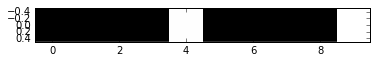

In [92]:
outp = colimit_of_pattern(dp[patt_len][0], proj_weight_mat, activation=0.348)
plt.imshow(outp.reshape(1,10), interpolation='none', cmap=plt.cm.gray) 
plt.show()

In [76]:
#check whether colimit is strongly connected
#get weights in layer 1
x = model.weights[4]
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
rec_weight_mat_2 = sess.run(x)    

lp, lpnd, dp = find_pattern_by_weight(7, rec_weight_mat_2, 0.42, 3)

In [77]:
print(dp)
#there is at least one pattern that is like the colimit
#but pattern for increased activation limit colimit is not in possible colimits

{2: [[7, 2], [7, 4]], 3: [[7, 2, 5], [7, 4, 9]]}
